
<div >
    <img src = "../banner/banner_ML_UNLP_1900_200.png" />
</div>



<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/ML_UNLP_Lectures/blob/main/Week05/Notebook_SS05_NN_R.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Problemas de Regresión con Redes Neuronales usando Keras (R)


# Predicting Wages

Nuestro objetivo es construir un modelo de salarios individuales

$$
w = f(X) + u 
$$

donde $w$ es el salario e $X$ es una matriz que incluye variables explicativas/predictoras. Nos enfocamos en un modelo lineal de la forma

\begin{align}
 ln(w) & = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p  + u 
\end{align}

donde $ln(w)$ es el logaritmo del salario.

Usaremos una muestra de la encuesta NLSY97. La NLSY97 es una muestra representativa de 8.984 mujeres y varones nacidos entre 1980 y 1984 y residentes en EE.UU. Las entrevistas se realizaron anualmente desde 1997 hasta 2011 y luego de manera bienal.

Carguemos los módulos y los datos.


In [1]:
require("pacman")
p_load(tidyverse)
p_load(keras3)


nlsy <- readr::read_csv('https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/nlsy97.csv')
head(nlsy)


Loading required package: pacman

Rows: 1266 Columns: 994
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (994): lnw_2016, educ, black, hispanic, other, exp, afqt, mom_educ, dad_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


lnw_2016,educ,black,hispanic,other,exp,afqt,mom_educ,dad_educ,yhea_100_1997,⋯,_XPexp_13,_XPexp_14,_XPexp_16,_XPexp_17,_XPexp_18,_XPexp_19,_XPexp_20,_XPexp_21,_XPexp_22,_XPexp_23
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.076898,16,0,0,0,11,7.0724,12,12,3,⋯,0,0,0,0,0,0,0,0,0,0
3.294138,9,0,0,0,19,4.7481,9,10,2,⋯,0,0,0,0,0,1,0,0,0,0
2.830896,9,0,1,0,22,1.1987,12,9,3,⋯,0,0,0,0,0,0,0,0,1,0
4.306459,16,0,0,0,13,8.9321,16,18,2,⋯,1,0,0,0,0,0,0,0,0,0
5.991465,16,0,1,0,15,2.2618,16,16,1,⋯,0,0,0,0,0,0,0,0,0,0
4.711924,16,0,0,0,14,8.9502,18,20,1,⋯,0,1,0,0,0,0,0,0,0,0


## Preparar conjuntos de entrenamiento y prueba

In [2]:

vars <- c('educ', 'exp', 'afqt', 'mom_educ', 'dad_educ')
X <- nlsy |> dplyr::select(all_of(vars))
y <- nlsy |> dplyr::select(lnw_2016)

n <- nrow(nlsy)
idx <- sample(seq_len(n), size = floor(0.7 * n))

X_train <- as.matrix(X[idx, ])
X_test  <- as.matrix(X[-idx, ])
y_train <- as.matrix(y[idx, ])
y_test  <- as.matrix(y[-idx, ])

dim(X_train)


[1] 886   5


## Keras

Utilizaremos las librerías `keras` y `tensorflow` en su interfaz para R, dos paquetes fundamentales en el área de deep learning.

`keras` es una interfaz de alto nivel para construir y entrenar modelos de aprendizaje profundo. Permite crear modelos con pocas líneas de código y se integra con TensorFlow en R mediante `reticulate`.

Keras ofrece una amplia gama de bloques para construir modelos de redes neuronales, funciones de pérdida, optimizadores y métricas de evaluación.



## Armando la primer red

### Configurar las capas 

La arquitectura de una red neuronal se construye a partir de capas. Inicializamos un modelo secuencial y luego agregamos las capas con la cantidad de neuronas y funciones de activación apropiadas.


In [3]:
model <- keras_model_sequential(input_shape = c(5))

model |>
  layer_dense(units = 10, activation = 'relu') |>
  layer_dense(units = 1, activation = 'linear')


### Compilar el modelo

Antes de entrenar definimos la función de pérdida, el optimizador y las métricas que mediremos.


In [4]:

model |> compile(
  loss = 'mse',
  optimizer = optimizer_adam(),
  metrics = list('mae')
)

summary(model)


Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                     │ (None, 10)               │            60 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_1 (Dense)                   │ (None, 1)                │            11 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 71 (284.00 B)
 Trainable params: 71 (284.00 B)
 Non-trainable params: 0 (0.00 B)



### Entrenar el modelo 

Entrenamos el modelo con `fit`, especificando número de épocas y tamaño de lote.


In [8]:

history <- model |> fit(
  X_train, y_train,
  batch_size = 128,
  epochs = 30,
  verbose = 0
)


#### Curva de error

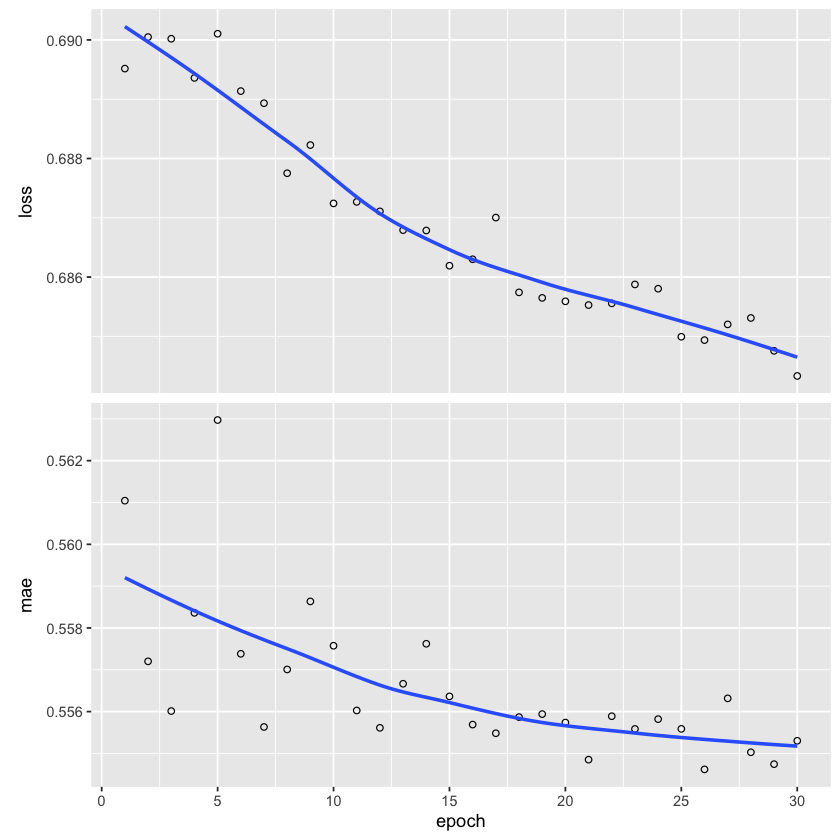

In [9]:

plot(history)


### Evaluar sobre el set de prueba

In [7]:

model |> evaluate(X_test, y_test, verbose = 1)


$loss
[1] 0.7317916

$mae
[1] 0.5601076

## Arquitectura de redes y capas múltiples

In [13]:

model <- keras_model_sequential() |> 
  layer_dense(units = 32, activation = 'relu', input_shape = ncol(X_train)) |> 
  layer_dense(units = 16, activation = 'tanh') |> 
  layer_dense(units = 1, activation = 'linear')

model |> compile(
  loss = 'mse',
  optimizer = optimizer_adam(),
  metrics = list('mae')
)

summary(model)


Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                   │ (None, 32)               │           192 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_6 (Dense)                   │ (None, 16)               │           528 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_7 (Dense)                   │ (None, 1)                │            17 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 737 (2.88 KB)
 Trainable params: 737 (2.88 KB)
 Non-trainable params: 0 (0.00 B)


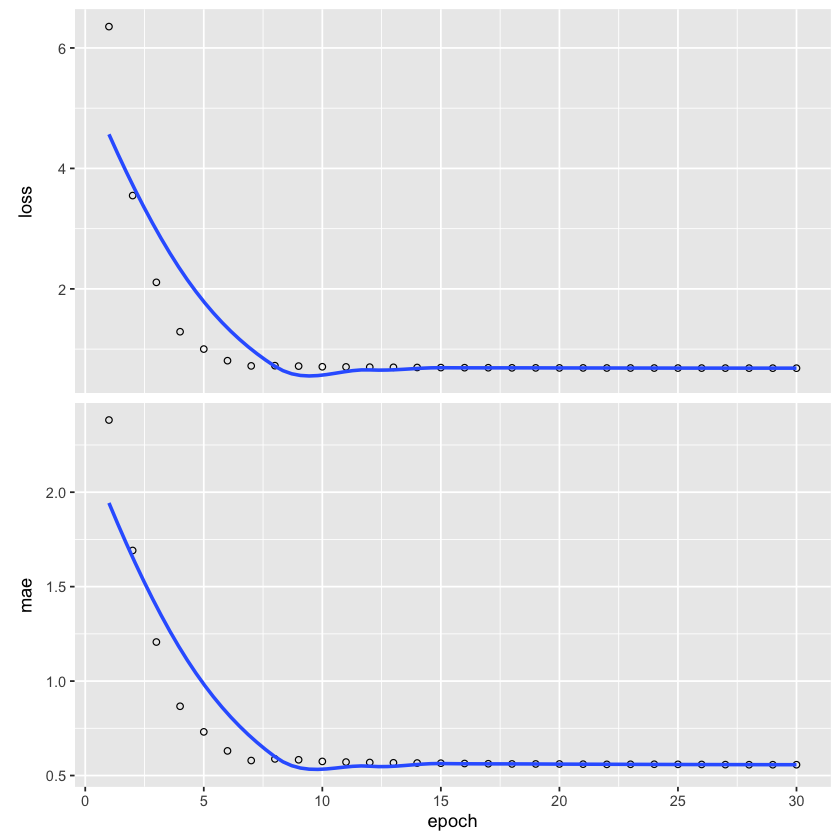

In [14]:

history <- model |> fit(
  X_train, y_train,
  batch_size = 128,
  epochs = 30,
  verbose = 0
)

plot(history)


In [15]:

model |> evaluate(X_test, y_test, verbose = 1)


$loss
[1] 0.7236816

$mae
[1] 0.5656578


## Regularización y Dropout

La regularización ayuda a reducir el sobreajuste penalizando pesos o apagando neuronas durante el entrenamiento.

* **L2 (ridge)**: agrega un término que penaliza pesos grandes.
* **L1 (lasso)**: incentiva pesos cercanos a cero y promueve esparsidad.
* **Dropout**: apaga aleatoriamente una fracción de neuronas en cada paso de entrenamiento, forzando a la red a aprender representaciones más robustas.

A continuación entrenamos un modelo con L2 + L1 y capas de `dropout`.


In [23]:

reg_model <- keras_model_sequential() |> 
  layer_dense(
    units = 32, activation = 'relu', input_shape = ncol(X_train),
    kernel_regularizer = regularizer_l2(l = 1e-3)
  ) |> 
  layer_dropout(rate = 0.3) |> 
  layer_dense(
    units = 64, activation = 'relu',
    kernel_regularizer = regularizer_l1_l2(l1 = 1e-4, l2 = 1e-3)
  ) |> 
  layer_dropout(rate = 0.2) |> 
  layer_dense(units = 1, activation = 'linear')

reg_model |> compile(
  loss = 'mse',
  optimizer = optimizer_adam(learning_rate = 0.001),
  metrics = list('mae')
)

reg_history <- reg_model |> fit(
  X_train, y_train,
  validation_split = 0.2,
  batch_size = 128,
  epochs = 30,
  verbose = 0
)


### Curvas de entrenamiento y validación con regularización

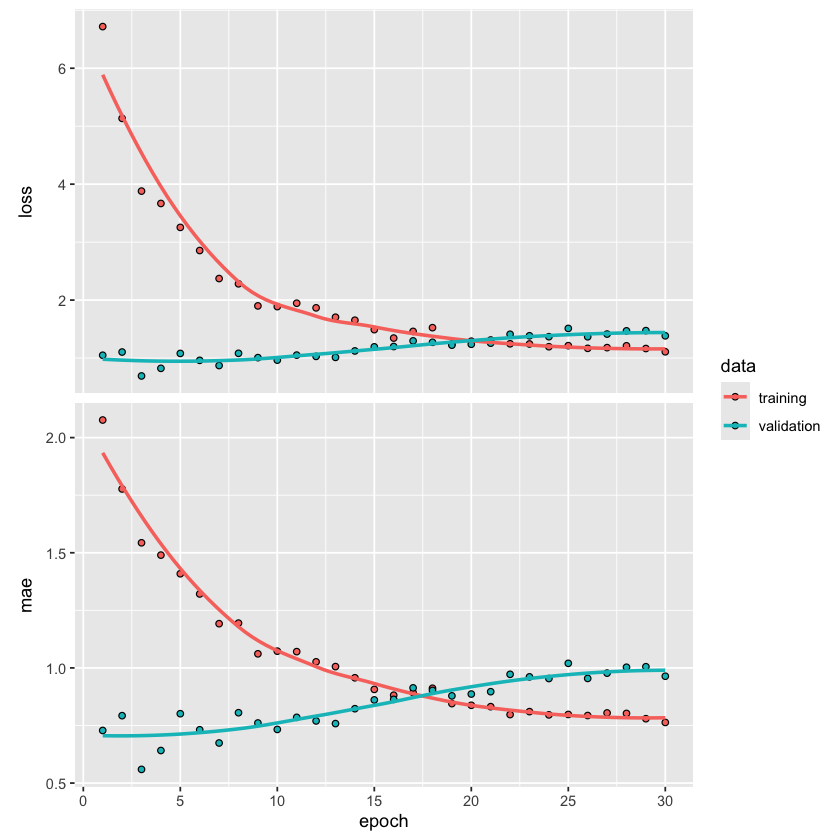

In [24]:

plot(reg_history)


### Evaluación final

In [25]:

reg_model |> evaluate(X_test, y_test, verbose = 1)


$loss
[1] 1.456822

$mae
[1] 0.9462093